# Importing Libraries 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Dropout, concatenate, BatchNormalization, MultiHeadAttention, LayerNormalization, LeakyReLU, Flatten,
                                      Embedding, Lambda, Add,  Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Bidirectional, LSTM)
from tensorflow.keras.optimizers import Adam
import json
import os

# Data Loading and Exploration

In [2]:
excel_path = r'c:/Users/LENOVO/OneDrive/Desktop/capstone project/13059_2018_1459_MOESM5_ESM.xlsx'
xls = pd.ExcelFile(excel_path)
sheets = xls.sheet_names
dfs = {sheet: xls.parse(sheet) for sheet in sheets}

hct116_df=dfs['hct116']
hek293t_df=dfs['hek293t']
hela_df=dfs['hela']
hl60_df=dfs['hl60']

In [3]:
print(f'HCT116 shape: {hct116_df.shape}')
print(f'HEK293T shape: {hek293t_df.shape}')
print(f'HELA shape: {hela_df.shape}')
print(f'HL60 shape: {hl60_df.shape}')

HCT116 shape: (4239, 6)
HEK293T shape: (2333, 6)
HELA shape: (8101, 6)
HL60 shape: (2076, 6)


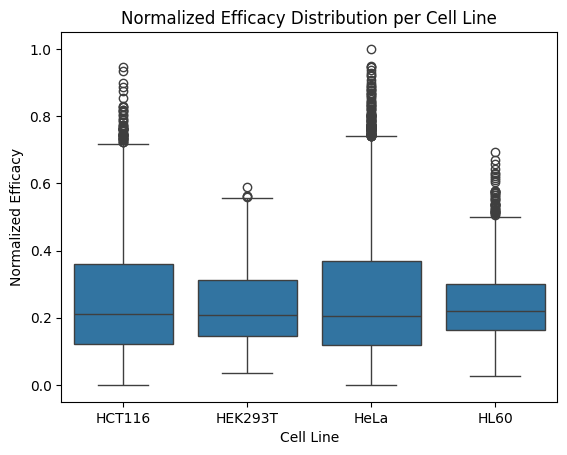

In [4]:
combined_df = pd.concat([
    hct116_df.assign(CellLine='HCT116'),
    hek293t_df.assign(CellLine='HEK293T'),
    hela_df.assign(CellLine='HeLa'),
    hl60_df.assign(CellLine='HL60')
])

sns.boxplot(data=combined_df, x='CellLine', y='Normalized efficacy')
plt.title('Normalized Efficacy Distribution per Cell Line')
plt.ylabel('Normalized Efficacy')
plt.xlabel('Cell Line')
plt.show()

In [5]:
'''
hct116_df.to_csv('hct116.csv', index=False)
hek293t_df.to_csv('hek293t.csv', index=False)
hela_df.to_csv('hela_df.csv', index=False)
hl60_df.to_csv('hl60_df.csv', index=False)
'''

"\nhct116_df.to_csv('hct116.csv', index=False)\nhek293t_df.to_csv('hek293t.csv', index=False)\nhela_df.to_csv('hela_df.csv', index=False)\nhl60_df.to_csv('hl60_df.csv', index=False)\n"

In [6]:
df=hek293t_df.copy()

In [7]:
df

,Chromosome,Start,End,Strand,sgRNA,Normalized efficacy
0,chr16,28602245,28602267,-,GGCTGCTTTACCCGCTGTGGGGG,0.323783
1,chr16,28602131,28602153,-,TCCGGGTTGGCCTTCCACTGGGG,0.349162
2,chr16,28600418,28600440,+,CAGCATCCTTCGGAAAGCTCTGG,0.280197
3,chr16,28602206,28602228,-,CGGTAGAAGCAGGTAGTCTGGGG,0.226491
4,chr16,28602121,28602143,+,CATCCCGCTGCCCCAGTGGAAGG,0.255358
...,...,...,...,...,...,...
2328,chr4,7045471,7045493,+,CGGCGGGCGCTTCACGCTCTGGG,0.485874
2329,chr4,7056389,7056411,+,CTGCAGCGGTACCGGCGAAACGG,0.512625
2330,chr4,7056698,7056720,-,AGGACTTTGTCCAGGTAGCTAGG,0.499876
2331,chr4,7056307,7056329,-,ACTCCTTGCATGACATGAACTGG,0.555058


In [8]:
df.shape

(2333, 6)

In [9]:
print("Max:", round(df['Normalized efficacy'].max(),3))
print("Min:", round(df['Normalized efficacy'].min(),3))

p1 = df['Normalized efficacy'].quantile(0.25)
p2 = df['Normalized efficacy'].quantile(0.50)
p3 = df['Normalized efficacy'].quantile(0.75)

print("25th percentile (Q1):", round(p1,3))
print("50th percentile (Median):", round(p2,3))
print("75th percentile (Q3):", round(p3,3))

Max: 0.59
Min: 0.037
25th percentile (Q1): 0.147
50th percentile (Median): 0.208
75th percentile (Q3): 0.311


In [10]:
df.describe()

,Start,End,Normalized efficacy
count,2.333000e+03,2.333000e+03,2333.000000
mean,6.469516e+07,6.469518e+07,0.237606
std,5.461508e+07,5.461508e+07,0.119823
min,7.045291e+06,7.045313e+06,0.036910
25%,2.958885e+07,2.958888e+07,0.146580
50%,7.033970e+07,7.033972e+07,0.208087
75%,7.035424e+07,7.035426e+07,0.310825
max,2.254497e+08,2.254497e+08,0.590267


In [11]:
df.dtypes

Chromosome              object
Start                    int64
End                      int64
Strand                  object
sgRNA                   object
Normalized efficacy    float64
dtype: object

In [12]:
df.info

<bound method DataFrame.info of      Chromosome     Start       End Strand                    sgRNA  \
0         chr16  28602245  28602267      -  GGCTGCTTTACCCGCTGTGGGGG   
1         chr16  28602131  28602153      -  TCCGGGTTGGCCTTCCACTGGGG   
2         chr16  28600418  28600440      +  CAGCATCCTTCGGAAAGCTCTGG   
3         chr16  28602206  28602228      -  CGGTAGAAGCAGGTAGTCTGGGG   
4         chr16  28602121  28602143      +  CATCCCGCTGCCCCAGTGGAAGG   
...         ...       ...       ...    ...                      ...   
2328       chr4   7045471   7045493      +  CGGCGGGCGCTTCACGCTCTGGG   
2329       chr4   7056389   7056411      +  CTGCAGCGGTACCGGCGAAACGG   
2330       chr4   7056698   7056720      -  AGGACTTTGTCCAGGTAGCTAGG   
2331       chr4   7056307   7056329      -  ACTCCTTGCATGACATGAACTGG   
2332       chr4   7056196   7056218      +  CAATCTGGTGCCAGCCTTCCTGG   

      Normalized efficacy  
0                0.323783  
1                0.349162  
2                0.280197  
3  

In [13]:
df.isnull().sum()

Chromosome             0
Start                  0
End                    0
Strand                 0
sgRNA                  0
Normalized efficacy    0
dtype: int64

In [14]:
df.duplicated().sum()

0

# Data Augmentation

In [15]:
nucleotides = ['A', 'C', 'G', 'T']

def generate_sgrnas(sgRNA):
    augmented = []
    for i in nucleotides:
        for j in nucleotides:
            if sgRNA[0] == i and sgRNA[1] == j:
                continue
            new_sgRNA = i + j + sgRNA[2:]
            if len(new_sgRNA) == len(sgRNA):
                augmented.append(new_sgRNA)
    return random.sample(augmented, min(3, len(augmented)))

augmented_rows = []

for _, row in df.iterrows():
    sgRNA = row['sgRNA']
    aug_sgrnas = generate_sgrnas(sgRNA)
    for i in aug_sgrnas:
        new_row = row.copy()
        new_row['sgRNA'] = i
        augmented_rows.append(new_row)
        
df_augmented = pd.DataFrame(augmented_rows)

In [16]:
df_augmented.shape

(6999, 6)

In [17]:
df_combined= pd.concat([df, df_augmented], ignore_index=True)

In [18]:
df_combined = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)

In [19]:
'''
df_augmented.to_csv('hek293t_augmented.csv', index=False)
df_combined.to_csv('hek293t_combined.csv', index=False)
'''


"\ndf_augmented.to_csv('hek293t_augmented.csv', index=False)\ndf_combined.to_csv('hek293t_combined.csv', index=False)\n"

In [20]:
df=df_combined.copy()

In [21]:
df.shape

(9332, 6)

# Feature Engineering

In [22]:
def gc_content(seq):
    gc_count = seq.count('G') + seq.count('C')
    return (gc_count / len(seq)) * 100

df['GC content']= df['sgRNA'].apply(gc_content)

In [23]:
print("Minimum GC Content: " , round(df['GC content'].min(),3))
print("Maximum GC Content: ", round(df['GC content'].max(),3))

Minimum GC Content:  21.739
Maximum GC Content:  91.304


In [27]:
df['Length'] = df['sgRNA'].apply(len)
df['Length'].value_counts()

Length
23    9332
Name: count, dtype: int64

In [28]:
df['sgRNA_noPAM'] = df['sgRNA'].apply(lambda x: x[:-3])
df['Length_noPAM'] = df['sgRNA_noPAM'].apply(len)

In [29]:
df['Length_noPAM'].value_counts()

Length_noPAM
20    9332
Name: count, dtype: int64

In [30]:
df.columns

Index(['Chromosome', 'Start', 'End', 'Strand', 'sgRNA', 'Normalized efficacy',
       'GC content', 'Cluster', 'Length', 'sgRNA_noPAM', 'Length_noPAM'],
      dtype='object')

In [31]:
df=df.drop(['Length','Length_noPAM', 'sgRNA'], axis=1)
df

,Chromosome,Start,End,Strand,Normalized efficacy,GC content,Cluster,sgRNA_noPAM
0,chr17,29653222,29653244,-,0.144676,56.521739,1,GCGCTAGCTTGAGAGCATTG
1,chr17,29679374,29679396,+,0.142441,47.826087,1,ATAATCCATGAGCCTGGACA
2,chr1,166838724,166838746,+,0.458122,43.478261,2,GGAGGAAATCATTGTGAGAA
3,chrX,70355019,70355041,+,0.243511,60.869565,0,CCTCATCACGTGTGAGCCAC
4,chr17,29661852,29661874,-,0.077469,34.782609,1,TAGTGTTTCAATTCAATACC
...,...,...,...,...,...,...,...,...
9327,chrX,70344894,70344916,+,0.402491,65.217391,2,GAAGGTGAAGCCCCCACCCA
9328,chrX,70344906,70344928,-,0.140627,52.173913,1,TCTCAATCTTCTCCTTGGGT
9329,chrX,70356339,70356361,-,0.207799,69.565217,0,GCGCGGCTCCTCATCTTCTG
9330,chrX,70348240,70348262,+,0.161761,47.826087,1,TCCTCTAACAATGGCACTTG


# One Hot Encoding

In [32]:
nucleotides = ['A', 'T', 'C', 'G']
encoder = OneHotEncoder(categories=[nucleotides], handle_unknown='ignore')
def one_hot_encoder(sequence):
    seq_arr = np.array(list(sequence)).reshape(-1, 1)
    return encoder.fit_transform(seq_arr).toarray()

result = df['sgRNA_noPAM'].apply(one_hot_encoder)
one_hot_arr = np.stack(result.to_numpy())  # shape: (samples, seq_len, 4)

# K mer encoding

In [33]:
def kmer_encoder(seqs):
    kmers = []
    k=3
    for seq in seqs:
        kmer_list = [seq[i:i+k] for i in range(len(seq) - k + 1)]
        kmer_str = ' '.join(kmer_list)
        kmers.append(kmer_str)
    vectorizer = CountVectorizer()
    k_mer_arr = vectorizer.fit_transform(kmers).toarray()

    return k_mer_arr, vectorizer

kmer_arr, kmer_vec= kmer_encoder(df['sgRNA_noPAM'])

# Data Preperation & Splitting

## Data Preperation with One Hot Encoding

### With Feature Engineering

In [ ]:
strand_map = {'+': 0, '-': 1}
df['Strand'] = df['Strand'].map(strand_map)
df['Chromosome_number'] = df['Chromosome'].str.replace('chr', '', regex=False).astype(str)
df['Chromosome_number'] = df['Chromosome_number'].replace({'X': 23})
df['Chromosome_number'] = df['Chromosome_number'].astype(int)

features_df = df[['Chromosome_number', 'Start', 'End', 'Strand', 'GC content']].copy()

y = df['Normalized efficacy'].values

X_seq_train, X_seq_test, X_feat_train, X_feat_test, y_train, y_test = train_test_split(
    one_hot_arr, features_df, y, test_size=0.2, random_state=42
)

scaler_gc = MinMaxScaler()
X_feat_train['GC content'] = scaler_gc.fit_transform(X_feat_train[['GC content']])
X_feat_test['GC content'] = scaler_gc.transform(X_feat_test[['GC content']])

X_num_train = X_feat_train.values
X_num_test = X_feat_test.values

### Without Feature Engineering

In [ ]:
strand_map = {'+': 0, '-': 1}
df['Strand'] = df['Strand'].map(strand_map)
df['Chromosome_number'] = df['Chromosome'].str.replace('chr', '', regex=False).astype(str)
df['Chromosome_number'] = df['Chromosome_number'].replace({'X': 23})
df['Chromosome_number'] = df['Chromosome_number'].astype(int)

features_df = df[['Chromosome_number', 'Start', 'End', 'Strand']].copy()

y = df['Normalized efficacy'].valuesa

X_seq_train, X_seq_test, X_feat_train, X_feat_test, y_train, y_test = train_test_split(
    one_hot_arr, features_df, y, test_size=0.2, random_state=42
)

X_num_train = X_feat_train.values
X_num_test = X_feat_test.values

## Data Preperation with K-mers Encoding

### With Feature Engineering

In [ ]:
strand_map = {'+': 0, '-': 1}
df['Strand'] = df['Strand'].map(strand_map)
df['Chromosome_number'] = df['Chromosome'].str.replace('chr', '', regex=False).astype(str)
df['Chromosome_number'] = df['Chromosome_number'].replace({'X': 23})
df['Chromosome_number'] = df['Chromosome_number'].astype(int)

features_df = df[['Chromosome_number', 'Start', 'End', 'Strand', 'GC content']].copy()

y = df['Normalized efficacy'].values

X_seq_train, X_seq_test, X_feat_train, X_feat_test, y_train, y_test = train_test_split(
    kmer_arr, features_df, y, test_size=0.2, random_state=42
)

scaler_gc = MinMaxScaler()
X_feat_train['GC content'] = scaler_gc.fit_transform(X_feat_train[['GC content']])
X_feat_test['GC content'] = scaler_gc.transform(X_feat_test[['GC content']])

X_num_train = X_feat_train.values
X_num_test = X_feat_test.values

### Without Feature Engineering

In [ ]:
strand_map = {'+': 0, '-': 1}
df['Strand'] = df['Strand'].map(strand_map)
df['Chromosome_number'] = df['Chromosome'].str.replace('chr', '', regex=False).astype(str)
df['Chromosome_number'] = df['Chromosome_number'].replace({'X': 23})
df['Chromosome_number'] = df['Chromosome_number'].astype(int)

features_df = df[['Chromosome_number', 'Start', 'End', 'Strand']].copy()

y = df['Normalized efficacy'].values

X_seq_train, X_seq_test, X_feat_train, X_feat_test, y_train, y_test = train_test_split(
    kmer_arr, features_df, y, test_size=0.2, random_state=42
)

X_num_train = X_feat_train.values
X_num_test = X_feat_test.values

# Saving models

In [33]:
def save_run(type, model, data, encoding_method, feature_engineering, run_id, hyperparameters, metrics, plots):

    dir = os.path.join("/Users/LENOVO/OneDrive/Desktop/hek293t", "Testing Models")
    os.makedirs(dir, exist_ok=True)

    plot_paths = {}
    for name, fig in plots.items():
        path = os.path.join(dir, f"{name}_run{run_id}.png")
        fig.savefig(path)
        plt.close(fig)
        plot_paths[name] = path

    model_arch_path = None
    if model is not None:
        model_arch_path = os.path.join(dir, f"model_architecture_run_{run_id}.txt")
        with open(model_arch_path, "w", encoding="utf-8") as f:
            model.summary(print_fn=lambda x: f.write(x + "\n"))
    
    model_file_path = None
    if model is not None:
        model_file_path = os.path.join(dir, f"model_run_{run_id}.keras")
        model.save(model_file_path) 

    run = {
        "Model:": type,
        "Run_id": run_id,
        "Data": data,
        "Encoding Method": encoding_method,
        "Feature Engineering": feature_engineering,
        "Hyperparameters": hyperparameters,
        "Evaluation Metrics": metrics,
        "Plots": plot_paths,
        "Model Architecture": model_arch_path,
        "Model Path": model_file_path
    }

    json_path = os.path.join(dir, "runs.json")
    if os.path.exists(json_path):
        with open(json_path, "r") as f:
            all_runs = json.load(f)
    else:
        all_runs = []

    all_runs.append(run)

    with open(json_path, "w") as f:
        json.dump(all_runs, f, indent=2)
        
    print("Done")

# MLP

### Normal MLP

In [ ]:
#seq_len=20 #With one-hot encoding
#seq_input = Input(shape=(seq_len,4), name='seq_input') #With one-hot encoding
seq_len = 64  #With k-mers encoding
seq_input = Input(shape=(seq_len,), name="seq_input") #With k-mers encoding

#x1 = Flatten()(seq_input) #Only with 1-Hot encoding
x1 = Dense(256, kernel_initializer='he_normal')(seq_input) #seq_input instead of x1 if k-mers
x1 = LeakyReLU()(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.3)(x1)

x1 = Dense(128, kernel_initializer='he_normal')(x1)
x1 = LeakyReLU()(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)

x1 = Dense(64, kernel_initializer='he_normal')(x1)
x1 = LeakyReLU()(x1)
x1 = BatchNormalization()(x1)

features_input = Input(shape=(X_num_train.shape[1],), name='num_input')
x2 = Dense(64, activation='relu', kernel_initializer='he_normal')(features_input)
x2 = BatchNormalization()(x2)

all_input = concatenate([x1, x2])
z = Dense(128, activation='relu', kernel_initializer='he_normal')(all_input)
z = Dropout(0.2)(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(1, activation='linear')(z)

optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)
model = Model(inputs=[seq_input, features_input], outputs=z)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

history = model.fit(
    {'seq_input': X_seq_train, 'num_input': X_num_train},
    y_train,
    validation_data=({'seq_input': X_seq_test, 'num_input': X_num_test}, y_test),
    epochs= 400,
    batch_size= 32
)

In [54]:
y_pred= model.predict({'seq_input': X_seq_test, 'num_input': X_num_test})
y_pred = y_pred.ravel()
y_test = y_test.ravel()

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [55]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
spearman_corr, _ = spearmanr(y_test, y_pred)

metrics = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2,
    'Spearman': spearman_corr
}

print("MLP Evaluation Metrics:")
print(f"  MSE      : {round(mse,3)}")
print(f"  RMSE     : {round(rmse,3)}")
print(f"  MAE      : {round(mae,3)}")
print(f"  R2 Score : {round(r2,3)}")
print(f"  Spearman : {round(spearman_corr,3)}")

MLP Evaluation Metrics:
  MSE      : 0.006
  RMSE     : 0.079
  MAE      : 0.06
  R2 Score : 0.568
  Spearman : 0.721


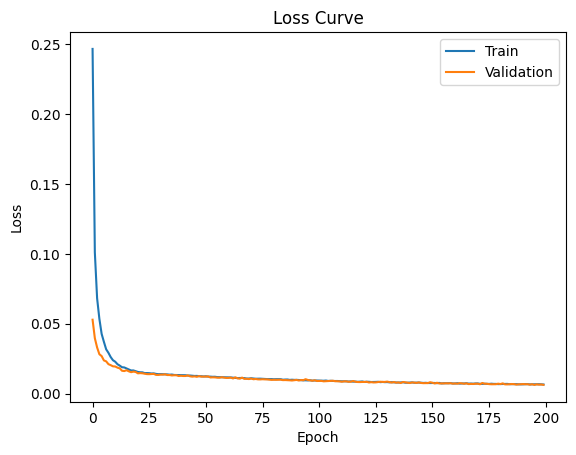

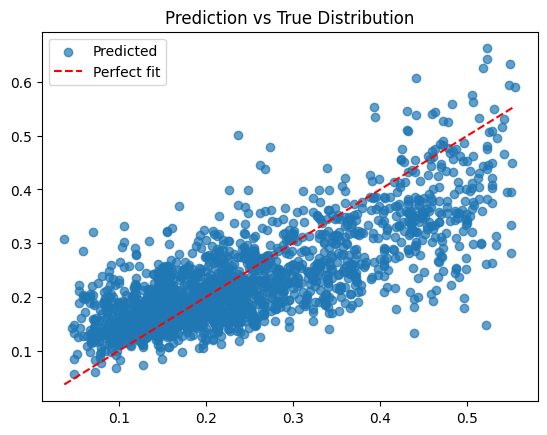

In [56]:
fig1, ax1 = plt.subplots()
ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Validation')
ax1.set_xlabel('Epoch')        
ax1.set_ylabel('Loss') 
ax1.set_title('Loss Curve')
ax1.legend()

fig2, ax2 = plt.subplots()
ax2.scatter(y_test, y_pred, alpha=0.7, label='Predicted')
ax2.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect fit') 
ax2.set_title('Prediction vs True Distribution')
ax2.legend()

In [ ]:
data= "Augmented Data"
encoding_method= 'K-mers Encoding'
feature_engineering= "With Feature Engineering"
run_id = 2
model_type = "MLP"
hyperparameters = {
    "epochs": 400,
    "batch_size": 32,
    "learning_rate": 1e-4
}

plots = {
    "Loss Curve": fig1,
    "Predicted vs. True Distribution": fig2
}

save_run(model_type, model, data, encoding_method, feature_engineering, run_id, hyperparameters, metrics, plots)

Done


### MLP with Attention

In [ ]:
seq_len = 20        
d_model = 16 

seq_input = Input(shape=(seq_len,4), name='seq_input')
x = Dense(d_model, use_bias=False)(seq_input)  # (Projection)
position_embed = Embedding(input_dim=seq_len, output_dim=d_model)

def add_positional_encoding(t):
    pe = position_embed(tf.range(seq_len))                         
    return t + tf.expand_dims(pe, 0)

x = Lambda(add_positional_encoding, name='add_pos')(x)   

attention_output = MultiHeadAttention(num_heads=2, key_dim=d_model // 2, dropout=0.1, name='self_attn')(x, x)      

x = Add(name='attn_res')([x, attention_output])
x = LayerNormalization(name='attn_ln')(x)
attention_output = Flatten(name='gap')(x)    

x1 = Dense(256, kernel_initializer='he_normal')(attention_output)
x1 = LeakyReLU()(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)

x1 = Dense(128, kernel_initializer='he_normal')(x1)
x1 = LeakyReLU()(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)

x1 = Dense(64, kernel_initializer='he_normal')(x1)
x1 = LeakyReLU()(x1)
x1 = BatchNormalization()(x1)

features_input = Input(shape=(X_num_train.shape[1],), name='num_input')
x2 = Dense(64, activation='relu', kernel_initializer='he_normal')(features_input)
x2 = BatchNormalization()(x2)

all_input = concatenate([x1, x2])
z = Dense(128, activation='relu', kernel_initializer='he_normal')(all_input)
z = Dropout(0.2)(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(1, activation='linear')(z)

optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)
model = Model(inputs=[seq_input, features_input], outputs=z)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

history = model.fit(
    {'seq_input': X_seq_train, 'num_input': X_num_train},
    y_train,
    validation_data=({'seq_input': X_seq_test, 'num_input': X_num_test}, y_test),
    epochs= 400,
    batch_size= 32
)

Epoch 1/200
234/234 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.2991 - mae: 0.4158 - val_loss: 0.0544 - val_mae: 0.1826
Epoch 2/200
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0898 - mae: 0.2333 - val_loss: 0.0373 - val_mae: 0.1508
Epoch 3/200
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0588 - mae: 0.1898 - val_loss: 0.0320 - val_mae: 0.1399
Epoch 4/200
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0470 - mae: 0.1709 - val_loss: 0.0265 - val_mae: 0.1269
Epoch 5/200
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0370 - mae: 0.1534 - val_loss: 0.0231 - val_mae: 0.1170
Epoch 6/200
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0322 - mae: 0.1421 - val_loss: 0.0214 - val_mae: 0.1119
Epoch 7/200
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0281 - mae: 0.1325 - val_loss: 0.0198 - val_mae: 0.1070
Epoch 8/200
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0252 - mae: 0.1260 - val_loss: 0.0175 - val_mae: 0.1015
Epoch 9/200
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/

In [33]:
y_pred= model.predict({'seq_input': X_seq_test, 'num_input': X_num_test})
y_pred = y_pred.ravel()
y_test = y_test.ravel()

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [34]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
spearman_corr, _ = spearmanr(y_test, y_pred)

metrics = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2,
    'Spearman': spearman_corr
}

print("MLP Evaluation Metrics:")
print(f"  MSE      : {round(mse,3)}")
print(f"  RMSE     : {round(rmse,3)}")
print(f"  MAE      : {round(mae,3)}")
print(f"  R2 Score : {round(r2,3)}")
print(f"  Spearman : {round(spearman_corr,3)}")

MLP Evaluation Metrics:
  MSE      : 0.001
  RMSE     : 0.037
  MAE      : 0.029
  R2 Score : 0.908
  Spearman : 0.935


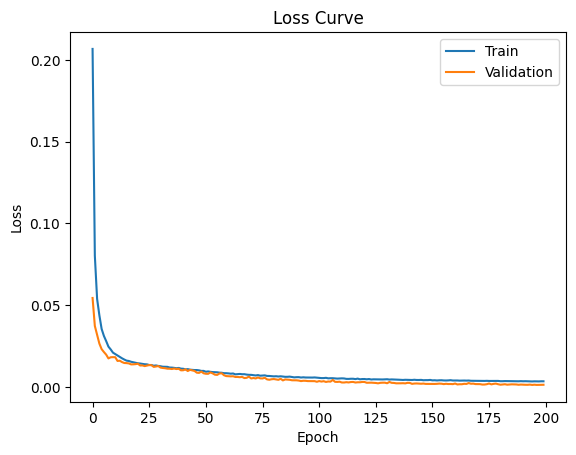

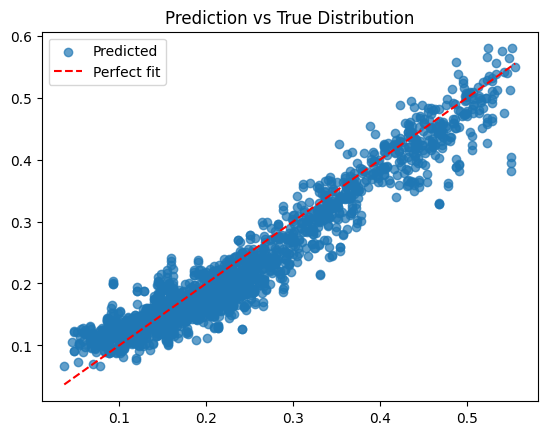

In [35]:
fig1, ax1 = plt.subplots()
ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Validation')
ax1.set_xlabel('Epoch')        
ax1.set_ylabel('Loss') 
ax1.set_title('Loss Curve')
ax1.legend()

fig2, ax2 = plt.subplots()
ax2.scatter(y_test, y_pred, alpha=0.7, label='Predicted')
ax2.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect fit') 
ax2.set_title('Prediction vs True Distribution')
ax2.legend()

In [ ]:
data= "Augmented Data"
encoding_method= '1 Hot Encoding + PE'
feature_engineering= "With Feature Engineering"
run_id = 3
model_type = "MLP + Attention"
hyperparameters = {
    "epochs": 400,
    "batch_size": 32,
    "learning_rate": 1e-4
}

plots = {
    "Loss Curve": fig1,
    "Predicted vs. True Distribution": fig2
}

save_run(model_type, model, data, encoding_method, feature_engineering, run_id, hyperparameters, metrics, plots)

Done


# CNN

### Normal CNN

In [ ]:
#seq_len=20 #With one-hot encoding
#seq_input = Input(shape=(seq_len,4), name='seq_input') #With one-hot encoding
seq_len = 64  #With k-mers encoding
seq_input = Input(shape=(seq_len, 1), name="seq_input") #With k-mers encoding

x1 = Conv1D(64, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(seq_input)
x1 = MaxPooling1D(pool_size=2)(x1)
x1 = BatchNormalization()(x1)

x1 = Conv1D(128, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x1)
x1 = MaxPooling1D(pool_size=2)(x1)
x1 = BatchNormalization()(x1)

x1 = Conv1D(128, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x1)
x1 = MaxPooling1D(pool_size=2)(x1)
x1 = BatchNormalization()(x1)

x1 = GlobalMaxPooling1D()(x1)

features_input = Input(shape=(X_num_train.shape[1],), name='num_input')
x2 = Dense(64, activation='relu', kernel_initializer='he_normal')(features_input)
x2 = BatchNormalization()(x2)

all_input = concatenate([x1, x2])
z = Dense(128, activation='relu', kernel_initializer='he_normal')(all_input)
z = Dropout(0.2)(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(1, activation='linear')(z)

optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)
model = Model(inputs=[seq_input, features_input], outputs=z)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

history = model.fit(
    {'seq_input': X_seq_train, 'num_input': X_num_train},
    y_train,
    validation_data=({'seq_input': X_seq_test, 'num_input': X_num_test}, y_test),
    epochs= 400,
    batch_size= 32
)

In [44]:
y_pred= model.predict({'seq_input': X_seq_test, 'num_input': X_num_test})
y_pred = y_pred.ravel()
y_test = y_test.ravel()

234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [45]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
spearman_corr, _ = spearmanr(y_test, y_pred)

metrics = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2,
    'Spearman': spearman_corr
}

print("MLP Evaluation Metrics:")
print(f"  MSE      : {round(mse,3)}")
print(f"  RMSE     : {round(rmse,3)}")
print(f"  MAE      : {round(mae,3)}")
print(f"  R2 Score : {round(r2,3)}")
print(f"  Spearman : {round(spearman_corr,3)}")

MLP Evaluation Metrics:
  MSE      : 0.002
  RMSE     : 0.042
  MAE      : 0.028
  R2 Score : 0.878
  Spearman : 0.922


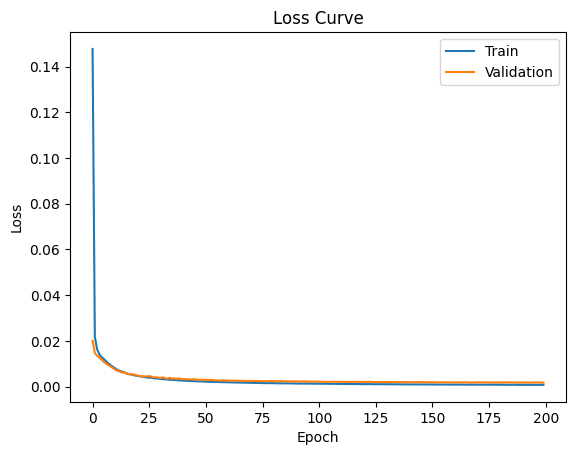

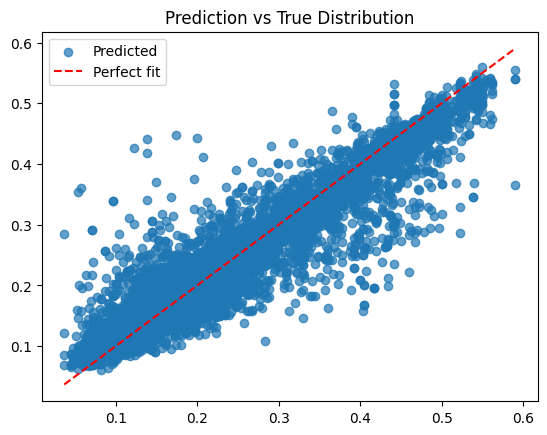

In [46]:
fig1, ax1 = plt.subplots()
ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Validation')
ax1.set_xlabel('Epoch')        
ax1.set_ylabel('Loss') 
ax1.set_title('Loss Curve')
ax1.legend()

fig2, ax2 = plt.subplots()
ax2.scatter(y_test, y_pred, alpha=0.7, label='Predicted')
ax2.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect fit') 
ax2.set_title('Prediction vs True Distribution')
ax2.legend()

In [ ]:
data= "Augmented Data"
encoding_method= 'K-mers Encoding'
feature_engineering= "With Feature Engineering"
run_id = 5
model_type = "CNN"
hyperparameters = {
    "epochs": 400,
    "batch_size": 32,
    "learning_rate": 1e-4
}

plots = {
    "Loss Curve": fig1,
    "Predicted vs. True Distribution": fig2
}

save_run(model_type, model, data, encoding_method, feature_engineering, run_id, hyperparameters, metrics, plots)

Done


### CNN with Attention

In [ ]:
seq_len=20 
d_model = 16 

seq_input = Input(shape=(seq_len,4), name='seq_input') 
x = Dense(d_model, use_bias=False)(seq_input)  #  (Projection)
position_embed = Embedding(input_dim=seq_len, output_dim=d_model)

def add_positional_encoding(t):
    pe = position_embed(tf.range(seq_len))                         
    return t + tf.expand_dims(pe, 0)

x = Lambda(add_positional_encoding, name='add_pos')(x)   

attention_output = MultiHeadAttention(num_heads=2, key_dim=d_model // 2, dropout=0.1, name='self_attn')(x, x)      

x = Add(name='attn_res')([x, attention_output])
x = LayerNormalization(name='attn_ln')(x)     

x1 = Conv1D(64, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
x1 = MaxPooling1D(pool_size=2)(x1)
x1 = BatchNormalization()(x1)

x1 = Conv1D(128, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x1)
x1 = MaxPooling1D(pool_size=2)(x1)
x1 = BatchNormalization()(x1)

x1 = Conv1D(128, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x1)
x1 = MaxPooling1D(pool_size=2)(x1)
x1 = BatchNormalization()(x1)

x1 = GlobalMaxPooling1D()(x1)

features_input = Input(shape=(X_num_train.shape[1],), name='num_input')
x2 = Dense(64, activation='relu', kernel_initializer='he_normal')(features_input)
x2 = BatchNormalization()(x2)

all_input = concatenate([x1, x2])
z = Dense(128, activation='relu', kernel_initializer='he_normal')(all_input)
z = Dropout(0.2)(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(1, activation='linear')(z)

optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)
model = Model(inputs=[seq_input, features_input], outputs=z)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

history = model.fit(
    {'seq_input': X_seq_train, 'num_input': X_num_train},
    y_train,
    validation_data=({'seq_input': X_seq_test, 'num_input': X_num_test}, y_test),
    epochs= 400,
    batch_size= 32
)

In [35]:
y_pred= model.predict({'seq_input': X_seq_test, 'num_input': X_num_test})
y_pred = y_pred.ravel()
y_test = y_test.ravel()

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [36]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
spearman_corr, _ = spearmanr(y_test, y_pred)

metrics = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2,
    'Spearman': spearman_corr
}

print("MLP Evaluation Metrics:")
print(f"  MSE      : {round(mse,3)}")
print(f"  RMSE     : {round(rmse,3)}")
print(f"  MAE      : {round(mae,3)}")
print(f"  R2 Score : {round(r2,3)}")
print(f"  Spearman : {round(spearman_corr,3)}")

MLP Evaluation Metrics:
  MSE      : 0.001
  RMSE     : 0.031
  MAE      : 0.023
  R2 Score : 0.935
  Spearman : 0.958


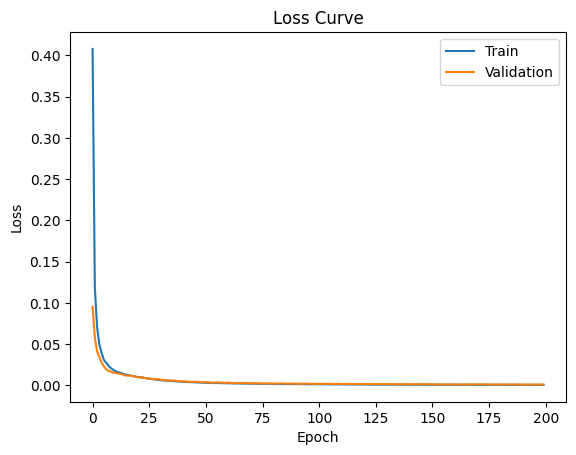

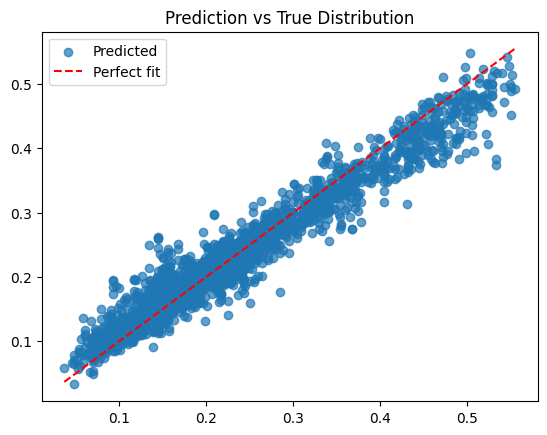

In [37]:
fig1, ax1 = plt.subplots()
ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Validation')
ax1.set_xlabel('Epoch')        
ax1.set_ylabel('Loss') 
ax1.set_title('Loss Curve')
ax1.legend()

fig2, ax2 = plt.subplots()
ax2.scatter(y_test, y_pred, alpha=0.7, label='Predicted')
ax2.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect fit') 
ax2.set_title('Prediction vs True Distribution')
ax2.legend()

In [ ]:
data= "Augmented Data"
encoding_method= '1 Hot Encoding + PE'
feature_engineering= "With Feature Engineering"
run_id = 6
model_type = "CNN + Attention"
hyperparameters = {
    "epochs": 400,
    "batch_size": 32,
    "learning_rate": 1e-4
}

plots = {
    "Loss Curve": fig1,
    "Predicted vs. True Distribution": fig2
}

save_run(model_type, model, data, encoding_method, feature_engineering, run_id, hyperparameters, metrics, plots)

Done


# BiLSTM

### Normal BiLSTM

In [ ]:
#seq_len=20 #With one-hot encoding
#seq_input = Input(shape=(seq_len,4), name='seq_input') #With one-hot encoding
seq_len = 64  #With k-mers encoding
seq_input = Input(shape=(seq_len,1), name="seq_input") #With k-mers encoding

x1 = Bidirectional(LSTM(64, return_sequences=True))(seq_input)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)

x1 = Bidirectional(LSTM(128, return_sequences=True))(x1)
x1 = GlobalMaxPooling1D()(x1)
x1 = BatchNormalization()(x1)

features_input = Input(shape=(X_num_train.shape[1],), name='num_input')
x2 = Dense(64, activation='relu', kernel_initializer='he_normal')(features_input)
x2 = BatchNormalization()(x2)

all_input = concatenate([x1, x2])
z = Dense(128, activation='relu', kernel_initializer='he_normal')(all_input)
z = Dropout(0.2)(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(1, activation='linear')(z)

optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)
model = Model(inputs=[seq_input, features_input], outputs=z)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

history = model.fit(
    {'seq_input': X_seq_train, 'num_input': X_num_train},
    y_train,
    validation_data=({'seq_input': X_seq_test, 'num_input': X_num_test}, y_test),
    epochs= 250,
    batch_size= 32
)

In [38]:
y_pred= model.predict({'seq_input': X_seq_test, 'num_input': X_num_test})
y_pred = y_pred.ravel()
y_test = y_test.ravel()

234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


In [39]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
spearman_corr, _ = spearmanr(y_test, y_pred)

metrics = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2,
    'Spearman': spearman_corr
}

print("MLP Evaluation Metrics:")
print(f"  MSE      : {round(mse,3)}")
print(f"  RMSE     : {round(rmse,3)}")
print(f"  MAE      : {round(mae,3)}")
print(f"  R2 Score : {round(r2,3)}")
print(f"  Spearman : {round(spearman_corr,3)}")

MLP Evaluation Metrics:
  MSE      : 0.003
  RMSE     : 0.052
  MAE      : 0.035
  R2 Score : 0.814
  Spearman : 0.876


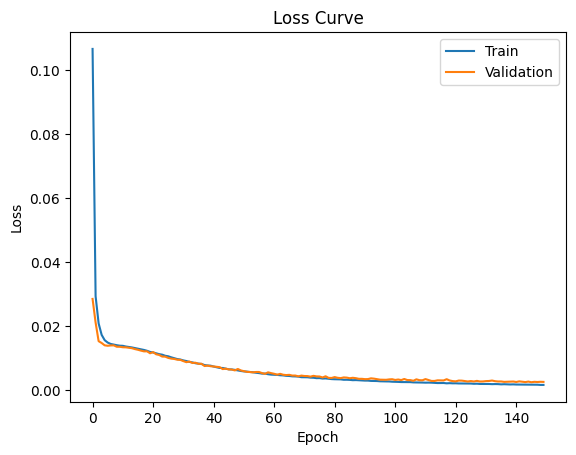

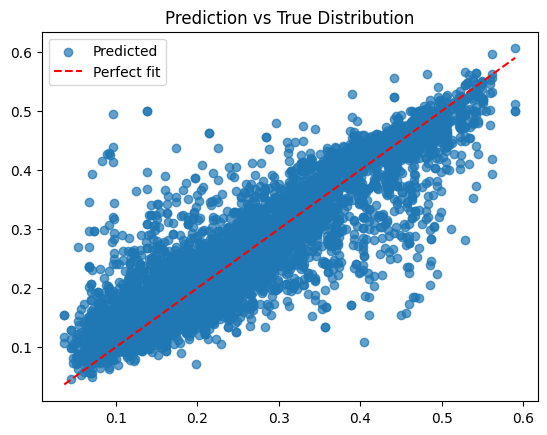

In [40]:
fig1, ax1 = plt.subplots()
ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Validation')
ax1.set_xlabel('Epoch')        
ax1.set_ylabel('Loss') 
ax1.set_title('Loss Curve')
ax1.legend()

fig2, ax2 = plt.subplots()
ax2.scatter(y_test, y_pred, alpha=0.7, label='Predicted')
ax2.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect fit') 
ax2.set_title('Prediction vs True Distribution')
ax2.legend()

In [ ]:
data= "Augmented Data"
encoding_method= 'K-mers Encoding'
feature_engineering= "With Feature Engineering"
run_id = 8
model_type = "BiLSTM"
hyperparameters = {
    "epochs": 250,
    "batch_size": 32,
    "learning_rate": 1e-4
}

plots = {
    "Loss Curve": fig1,
    "Predicted vs. True Distribution": fig2
}

save_run(model_type, model, data, encoding_method, feature_engineering, run_id, hyperparameters, metrics, plots)

Done


### BiLSTM with Attention

In [ ]:
seq_len=20 
d_model = 16 

seq_input = Input(shape=(seq_len,4), name='seq_input') 

x = Dense(d_model, use_bias=False)(seq_input)  # (Projection)
position_embed = Embedding(input_dim=seq_len, output_dim=d_model)

def add_positional_encoding(t):
    pe = position_embed(tf.range(seq_len))                         
    return t + tf.expand_dims(pe, 0)

x = Lambda(add_positional_encoding, name='add_pos')(x)   

attention_output = MultiHeadAttention(num_heads=2, key_dim=d_model // 2, dropout=0.1, name='self_attn')(x, x)      

x = Add(name='attn_res')([x, attention_output])
x = LayerNormalization(name='attn_ln')(x)     

x1 = Bidirectional(LSTM(64, return_sequences=True))(x)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)

x1 = Bidirectional(LSTM(128, return_sequences=True))(x1)
x1 = GlobalMaxPooling1D()(x1)
x1 = BatchNormalization()(x1)

features_input = Input(shape=(X_num_train.shape[1],), name='num_input')
x2 = Dense(64, activation='relu', kernel_initializer='he_normal')(features_input)
x2 = BatchNormalization()(x2)

all_input = concatenate([x1, x2])
z = Dense(128, activation='relu', kernel_initializer='he_normal')(all_input)
z = Dropout(0.2)(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(1, activation='linear')(z)

optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)
model = Model(inputs=[seq_input, features_input], outputs=z)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

history = model.fit(
    {'seq_input': X_seq_train, 'num_input': X_num_train},
    y_train,
    validation_data=({'seq_input': X_seq_test, 'num_input': X_num_test}, y_test),
    epochs= 250,
    batch_size= 32
)

In [35]:
y_pred= model.predict({'seq_input': X_seq_test, 'num_input': X_num_test})
y_pred = y_pred.ravel()
y_test = y_test.ravel()

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [36]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
spearman_corr, _ = spearmanr(y_test, y_pred)

metrics = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2,
    'Spearman': spearman_corr
}

print("MLP Evaluation Metrics:")
print(f"  MSE      : {round(mse,3)}")
print(f"  RMSE     : {round(rmse,3)}")
print(f"  MAE      : {round(mae,3)}")
print(f"  R2 Score : {round(r2,3)}")
print(f"  Spearman : {round(spearman_corr,3)}")

MLP Evaluation Metrics:
  MSE      : 0.002
  RMSE     : 0.039
  MAE      : 0.029
  R2 Score : 0.896
  Spearman : 0.935


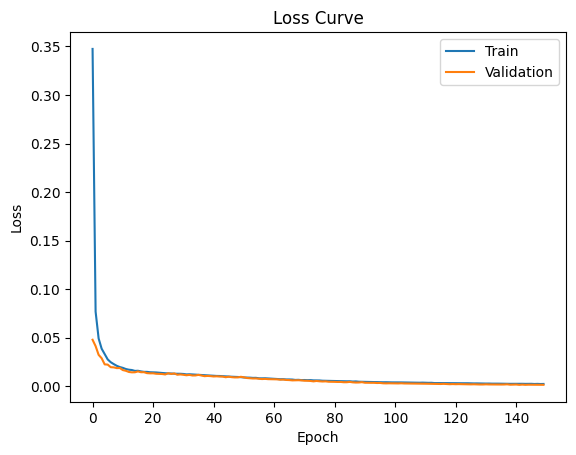

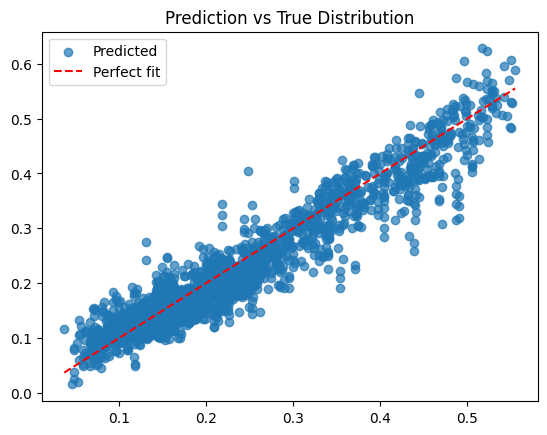

In [37]:
fig1, ax1 = plt.subplots()
ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Validation')
ax1.set_xlabel('Epoch')        
ax1.set_ylabel('Loss') 
ax1.set_title('Loss Curve')
ax1.legend()

fig2, ax2 = plt.subplots()
ax2.scatter(y_test, y_pred, alpha=0.7, label='Predicted')
ax2.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect fit') 
ax2.set_title('Prediction vs True Distribution')
ax2.legend()

In [ ]:
data= "Augmented Data"
encoding_method= '1 Hot Encoding + PE'
feature_engineering= "With Feature Engineering"
run_id = 9
model_type = "BiLSTM + Attention"
hyperparameters = {
    "epochs": 250,
    "batch_size": 32,
    "learning_rate": 1e-4
}

plots = {
    "Loss Curve": fig1,
    "Predicted vs. True Distribution": fig2
}

save_run(model_type, model, data, encoding_method, feature_engineering, run_id, hyperparameters, metrics, plots)

Done
